In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
%cd drive/My Drive/project/data_arg
!ls

/content/drive/My Drive/project/data_arg


In [ ]:
! git clone https://github.com/Paperspace/DataAugmentationForObjectDetection.git

Cloning into 'DataAugmentationForObjectDetection'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 141 (delta 0), reused 1 (delta 0), pack-reused 136
Receiving objects: 100% (141/141), 10.17 MiB | 12.08 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [ ]:
# csv_path = '/content/drive/My Drive/project/mango/sample/label'
# image_path = '/content/drive/My Drive/project/mango/sample/image'

# csv_path = '/content/drive/My Drive/project/mango/train_dev/'
# image_path = '/content/drive/My Drive/project/mango/train_dev/Train/'

# csv_path = '/content/drive/My Drive/project/mango/train_dev/'
# image_path = '/content/drive/My Drive/project/mango/train_dev/Dev/'

csv_path = '/content/drive/My Drive/project/mango/test/'
image_path = '/content/drive/My Drive/project/mango/test/image/Test/'

In [ ]:
def load_csv(csv_path, file_name):
    # dataset = pd.read_csv(os.path.join(csv_path, file_name), header = None, low_memory = False)
    dataset = pd.read_csv(os.path.join(csv_path, file_name), low_memory = False)
    return dataset

dataset = load_csv(csv_path, 'Test_mangoXYWH.csv')
dataset = np.array(dataset)

In [ ]:
x_y_min = dataset[:, 1:3].astype(np.int32)
x_y_max = np.add(dataset[:, 1:3], dataset[:, 3:]).astype(np.int)
b_box = np.concatenate((x_y_min, x_y_max), axis = 1)

In [ ]:
b_box

#Data Argumation

In [ ]:
'''
Rotate image and compute new bounding box
@param image - image to be rotated
@param angle - rotation angle
@param bounding_box - original bounding box
@return: the rotated image and the new bounding box
'''
def rotate_image(image, angle, bounding_box):
  # get image dimension
  img_height, img_width = image.shape[:2]

  # get rotation matrix
  rotation_matrix = cv2.getRotationMatrix2D( center = (img_width // 2, img_height // 2), angle = angle, scale = 1.0 )

  # apply transformation (ratate image) 
  rotated_image = cv2.warpAffine( image, rotation_matrix, (img_width, img_height) )

  # --- compute new bounding box ---
  # Apply same transformation to the four bounding box corners
  rotated_point_A = np.matmul( rotation_matrix, np.array( [bounding_box[0], bounding_box[1], 1] ).T )   
  rotated_point_B = np.matmul( rotation_matrix, np.array( [bounding_box[2], bounding_box[1], 1] ).T )   
  rotated_point_C = np.matmul( rotation_matrix, np.array( [bounding_box[2], bounding_box[3], 1] ).T )   
  rotated_point_D = np.matmul( rotation_matrix, np.array( [bounding_box[0], bounding_box[3], 1] ).T )   
  # Compute new bounding box, that is, the bounding box for rotated object
  x = np.array( [ rotated_point_A[0], rotated_point_B[0], rotated_point_C[0], rotated_point_D[0] ] )
  y = np.array( [ rotated_point_A[1], rotated_point_B[1], rotated_point_C[1], rotated_point_D[1] ] )
  new_boundingbox = [np.min( x ).astype(int), np.min( y ).astype(int), np.max( x ).astype(int), np.max( y ).astype(int)]

  return rotated_image, new_boundingbox


def width_shift_image( image, width_shift_range, boundingbox ):
    
  img_height, img_width = image.shape[:2]
  factor = img_width * width_shift_range

  M = np.float32([[1,0,factor],[0,1,0]]) 
  shifted_image = cv2.warpAffine( image, M, (img_width, img_height) )

  # compute new bounding box    
  shifted_point_A = np.matmul( M, np.array( [boundingbox[0], boundingbox[1], 1] ).T )   
  shifted_point_C = np.matmul( M, np.array( [boundingbox[2], boundingbox[3], 1] ).T )   

  new_boundingbox = [ shifted_point_A[0].astype(int), shifted_point_A[1].astype(int), 
                      shifted_point_C[0].astype(int), shifted_point_C[1].astype(int) ]

  return shifted_image, new_boundingbox


def height_shift_image( image, height_shift_range, boundingbox ):
    
  img_height, img_width = image.shape[:2]
  factor = height_shift_range * img_height
  
  M = np.float32([[1,0,0],[0,1,factor]]) 
  shifted_image = cv2.warpAffine( image, M, (img_width, img_height) )
  
  # compute new bounding box    
  shifted_point_A = np.matmul( M, np.array( [boundingbox[0], boundingbox[1], 1] ).T )   
  shifted_point_C = np.matmul( M, np.array( [boundingbox[2], boundingbox[3], 1] ).T )   
  
  new_boundingbox = [ shifted_point_A[0].astype(int), shifted_point_A[1].astype(int), 
                      shifted_point_C[0].astype(int), shifted_point_C[1].astype(int) ]
  
  return shifted_image, new_boundingbox

def scale_image(image, scale_factor, boundingbox ):

  img_height, img_width = image.shape[:2]

  width = (int)(scale_factor * img_width)
  height = (int)(scale_factor * img_height)
  
  scaled_img = cv2.resize(image, (width,height))

  scaling_marix = np.array( [ [scale_factor, 0, 0], [0, scale_factor, 0], [0, 0, scale_factor] ] )

  scaled_point_A = np.matmul( scaling_marix, np.array( [boundingbox[0], boundingbox[1], 1] ).T )   
  scaled_point_C = np.matmul( scaling_marix, np.array( [boundingbox[2], boundingbox[3], 1] ).T )   

  new_boundingbox = [ scaled_point_A[0].astype(int), scaled_point_A[1].astype(int), 
                      scaled_point_C[0].astype(int), scaled_point_C[1].astype(int) ]
  
  return scaled_img, new_boundingbox


t_dic = { "rotation":rotate_image, "width_shift":width_shift_image, 
         "height_shift":height_shift_image, "scale": scale_image }
f_dic = { "rotation":(0, 90), "width_shift":(0, 0.5), "height_shift":(0, 0.5), "scale": (0.5, 1.5)}

'''
Apply the specidied transdormation n times
return: a list with all transformated images, it bounding box and the value factor used.
'''
def apply_transformation(image, bounding_box, transformation, n):

  t_images_list = []
  for i in range(0, n):
    interval = f_dic[transformation]
    factor = random.uniform(interval[0], interval[1])
    img, bb = t_dic[transformation](image, factor, bounding_box)
    t_images_list.append( (img, bb, factor))

  return t_images_list

#Useful function

In [ ]:
def read_image( image_path ): 
  image = plt.imread((os.path.join(image_path, image_name)))
  return image
    # image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)        
    # return image

'''
Draw the bounding box on image
@param image - the image 
@param tl - bounding box top left corner
@param br - bounding box top bottom right
@return: a copy of input image with the bounding box on it
'''
def draw_boundingbox(image, tl, br):
  # plt.figure()
  # fig,ax = plt.subplots(1)
  # ax.imshow(img)
  # x, y, w, h = dataset[i][1:].astype(np.int32)
  # x, y, w, h = int(np.round(x * x_scale)), int(np.round(y * y_scale)),\
  #              int(np.round(w * x_scale)), int(np.round(h * y_scale))
  # rect = patches.Rectangle((x, y), w, h, linewidth = 2, edgecolor = 'r', facecolor = 'none')
  # ax.add_patch(rect)
  # plt.show()
  copied_image = image.copy()
  image = cv2.rectangle(copied_image, tl, br, (255, 0, 0), 10)          
  return copied_image

'''Show image'''
def show_image( image ):
    # Drawing picture
    #plt.figure( figsize = (15,15) )
    plt.axis('off')
    plt.imshow( image )
    plt.show()

'''Plot all images in a list'''
def plot_images( images_list ):
    import math
    num_cols = 5
    num_rows = math.ceil( len(images_list) / num_cols )
    figsize = (10,10)
    fig = plt.figure( figsize=figsize)

    for i in range (0, len(images_list) ):
        info = images_list[i]
        x1, y1, x2, y2 = info[1]
        image = draw_boundingbox( info[0], (x1, y1), (x2, y2) )
        
        axi = fig.add_subplot(num_rows, num_cols, i+1)
        axi.axis( 'off' )
        axi.set_title( ("%.1f" % info[2] ) )
        axi.imshow( image )
def scale_bbox(cor, x_scale, y_scale):
  x, y, w ,h = cor
  x, y ,w ,h = int(np.round(x * x_scale)), int(np.round(y * y_scale)),\
           int(np.round(w * x_scale)), int(np.round(h * y_scale))
  return x, y ,w ,h    

# Write TFRecord Dataset

In [ ]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list = tf.train.FloatList(value = [value]))


def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list = tf.train.Int64List(value = [value]))

def serialize_array(array):
  array = tf.io.serialize_tensor(array)
  return array

def segment(data):
    feature_set= []
    img_name = []
    demension = len(data[0])
    segment = list(range(1, demension, 5))
    for i in range(len(data)):
        for seg in segment:
            if data[i][seg] == '1':
                pass
            else:
                sub_data = data[i][seg:seg + 5]
                img = data[i][0]
                feature_set.append(sub_data)
                img_name.append(img)
    img_name = np.array(img_name)
    feature_set = np.array(feature_set)
    label = feature_set[:,4]
    w_h = feature_set[:,:4].astype('float32')
    return img_name, feature_set, label, w_h


def image_example(image, b_box):
    # image = plt.imread(os.path.join(image_path, file_name))
    # image_string = open(os.path.join(image_path, file_name), 'rb').read()
    # image_shape = tf.image.decode_jpeg(image_string).shape
    image_string = tf.image.encode_jpeg(image)
    feature = {
      'image_raw': _bytes_feature(image_string),
      'target':_bytes_feature(b_box),
    }
    return tf.train.Example(features = tf.train.Features(feature = feature))

def image_example_2(image, cordinate):
    image_string = tf.image.encode_jpeg(image)
    feature = {
      'image_raw': _bytes_feature(image_string),
      'cordinate' : _bytes_feature(cordinate)
    }
    return tf.train.Example(features = tf.train.Features(feature = feature))
def y_label(label):
  target = np.zeros((5,4), dtype = 'float32')
  if label == '不良-乳汁吸附':
    o_h_e[0,0] = 1
  elif label == '不良-機械傷害':
    o_h_e[0,1] = 1
  elif label == '不良-炭疽病':
    o_h_e[0,2] = 1
  elif label == '不良-著色不佳':
    o_h_e[0,3] = 1
  else:
    o_h_e[0,4] = 1
  # return o_h_e.tostring()
  return o_h_e.tobytes()
  # return o_h_e

def scale_bbox(cor, x_scale, y_scale):
  x, y, w, h = cor
  new_x, new_y, new_w, new_h = int(np.round(x * x_scale)), int(np.round(y * y_scale)), \
                               int(np.round(w * x_scale)), int(np.round(h * y_scale))
  return np.array([new_x / 224, new_y / 224, new_w / 224, new_h / 224]).astype(np.float32)

#Read TF Dataset

In [ ]:
BATCH_SIZE = 100
AUTOTUNE = tf.data.experimental.AUTOTUNE

def decode_image(image):
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = image/255
    # image = tf.reshape(image, [224, 224, 3])
    return image

def decode_label(label):
  label = tf.io.decode_raw(label, tf.float32)
  # label = p
  # label = tf.cast(label, tf.float32)
  return label

def read_tfrecord(example, labeled):
    tfrecord_format = (
        {
            'image_raw': tf.io.FixedLenFeature([], tf.string),
            'target': tf.io.FixedLenFeature([], tf.string),
        }
        if labeled
        else {"image_raw": tf.io.FixedLenFeature([], tf.string)}
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image_raw'])
    if labeled:
        label = decode_label(example['target'])
        # label = tf.cast(label, tf.int32)
        return image, label
    return image

def load_dataset(filenames, labeled = False):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = True  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames)  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order)  
# uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord, labeled = labeled), num_parallel_calls = AUTOTUNE)
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

def get_dataset(filenames, labeled = False):
    dataset = load_dataset(filenames, labeled = labeled)
#     dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size = AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

#Test

In [ ]:
cor = dataset[:, 1:].astype(int)
with tf.io.TFRecordWriter(os.path.join(csv_path, 'new_test_cor_.tfrecord')) as writer:
  a, b = 0, 0
  for i in range(len(dataset)):
    img_name = dataset[i, 0]
    if os.path.isfile(image_path + img_name):
      w_image = plt.imread(os.path.join(image_path, img_name))
      x_scale, y_scale = (224 / w_image.shape[1]), (224 / w_image.shape[0])
      w_image = cv2.resize(w_image, (224, 224))
      new_box = scale_bbox(cor[i], x_scale, y_scale)
      b_new_box = new_box.tobytes()
      tf_example = image_example(w_image, new_box)
      writer.write(tf_example.SerializeToString())
      b += 1
    a += 1
writer.close()
print(a, b)

7363 7363


In [ ]:
dataset[0,0]

'39983.jpg'

In [ ]:
np.random.shuffle(dataset)
x_y_min = dataset[:, 1:3].astype(np.int32)
x_y_max = np.add(dataset[:, 1:3], dataset[:, 3:]).astype(np.int)
b_box = np.concatenate((x_y_min, x_y_max), axis = 1)

In [ ]:
original_image = plt.imread(os.path.join(image_path, dataset[0,0]))
r_image = cv2.resize(original_image, (224, 224))

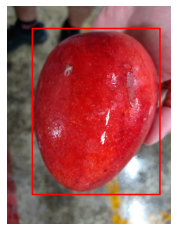

In [ ]:
show_image(draw_boundingbox( original_image, 
                             (b_box[0][0], b_box[0][1]),
                             (b_box[0][2], b_box[0][3])))

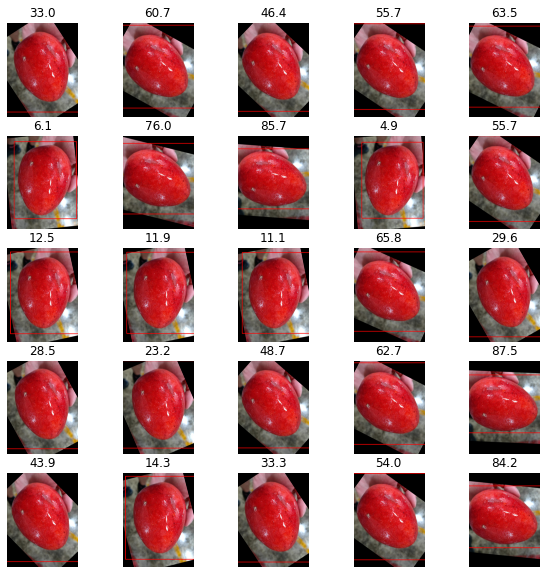

In [ ]:
rotated_images = apply_transformation( original_image, b_box[0], "rotation", 25 )
plot_images( rotated_images )

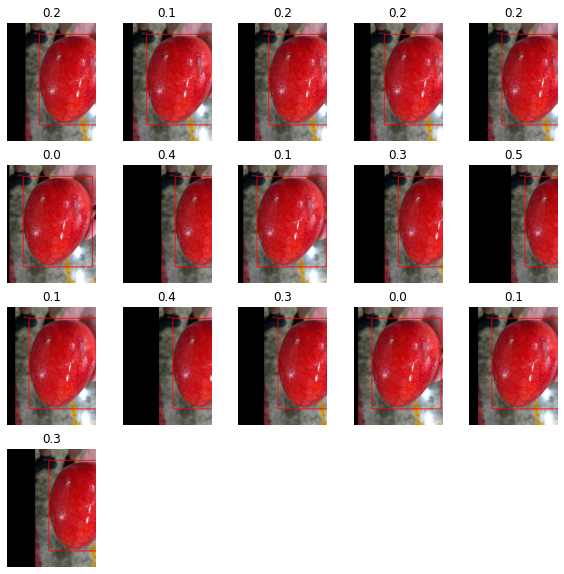

In [ ]:
w_shifted_images = apply_transformation( original_image, b_box[0], "width_shift", 16 )
plot_images( w_shifted_images )

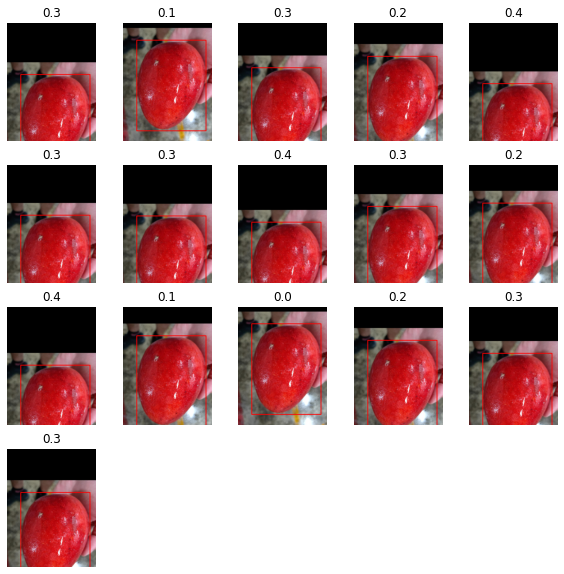

In [ ]:
h_shifted_images = apply_transformation( original_image, b_box[0], "height_shift", 16 )
plot_images( h_shifted_images )

In [ ]:
scaled_images = apply_transformation(original_image, b_box[0], "scale", 16 )
o_h, o_w = original_image.shape[:2]
for img in scaled_images:
    h, w = img[0].shape[:2]
    print( "Original size:", (o_w, o_h),  "  New size:", (w, h) )

Original size: (1344, 1008)   New size: (2004, 1503)
Original size: (1344, 1008)   New size: (1549, 1162)
Original size: (1344, 1008)   New size: (1693, 1269)
Original size: (1344, 1008)   New size: (1177, 883)
Original size: (1344, 1008)   New size: (1207, 905)
Original size: (1344, 1008)   New size: (1340, 1005)
Original size: (1344, 1008)   New size: (1360, 1020)
Original size: (1344, 1008)   New size: (846, 634)
Original size: (1344, 1008)   New size: (1106, 829)
Original size: (1344, 1008)   New size: (1788, 1341)
Original size: (1344, 1008)   New size: (1289, 966)
Original size: (1344, 1008)   New size: (1687, 1265)
Original size: (1344, 1008)   New size: (1936, 1452)
Original size: (1344, 1008)   New size: (845, 633)
Original size: (1344, 1008)   New size: (1837, 1378)
Original size: (1344, 1008)   New size: (1837, 1377)


In [ ]:
scaled_images = apply_transformation(original_image, b_box[0], "scale", 16 )
o_h, o_w = r_image.shape[:2]
for img in scaled_images:
    h, w = img[0].shape[:2]
    print( "Original size:", (o_w, o_h),  "  New size:", (w, h) )

Original size: (224, 224)   New size: (714, 535)
Original size: (224, 224)   New size: (894, 670)
Original size: (224, 224)   New size: (1040, 780)
Original size: (224, 224)   New size: (1826, 1369)
Original size: (224, 224)   New size: (1079, 809)
Original size: (224, 224)   New size: (1463, 1097)
Original size: (224, 224)   New size: (1703, 1277)
Original size: (224, 224)   New size: (1901, 1425)
Original size: (224, 224)   New size: (2009, 1507)
Original size: (224, 224)   New size: (1648, 1236)
Original size: (224, 224)   New size: (1833, 1375)
Original size: (224, 224)   New size: (1162, 871)
Original size: (224, 224)   New size: (1415, 1061)
Original size: (224, 224)   New size: (1915, 1436)
Original size: (224, 224)   New size: (1543, 1157)
Original size: (224, 224)   New size: (712, 534)


In [ ]:
plot_images( scaled_images )

In [ ]:
for i in range(5):
  print('Num.', i + 1)
  img = plt.imread(os.path.join(image_path, dataset[i][0]))
  x_scale, y_scale = (224 / img.shape[1]), (224 / img.shape[0])
  img = cv2.resize(img, (224, 224))
  plt.figure()
  fig,ax = plt.subplots(1)
  ax.imshow(img)
  x, y, w, h = dataset[i][1:].astype(np.int32)
  x, y, w, h = int(np.round(x * x_scale)), int(np.round(y * y_scale)),\
    int(np.round(w * x_scale)), int(np.round(h * y_scale))
  rect = patches.Rectangle((x, y), w, h, linewidth = 2, edgecolor = 'r', facecolor = 'none')
  #     rect = patches.Rectangle((340,135), 363, 252, linewidth = 2, edgecolor = 'r', facecolor = 'none')
  ax.add_patch(rect)
  plt.show()

In [ ]:
np.shape(rotated_images[0][0])

(1008, 1344, 3)